In [2]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim
from importlib import reload

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['svg.fonttype'] = 'none'

mouse_colors = {4:'blue', 5:'cornflowerblue', 6:'darkorange', 7:'darkgoldenrod'}


Muller plots

4 23 [ 0  1  2  3  4  5  6  7  9 14 16 17 18 19 20 21 22 27 29 33 36 40 54]
5 24 [ 0  1  2  3  4  5  6  7  9 12 14 16 17 18 19 20 21 22 27 29 33 36 40 54]
6 25 [ 0  1  2  3  4  5  6  7  9 12 14 15 16 17 18 19 20 21 22 27 29 33 36 40
 54]
7 23 [ 0  1  3  4  5  6  7  9 12 15 16 17 18 19 20 21 22 27 29 33 36 40 54]


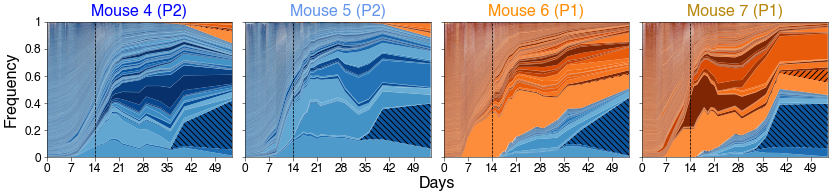

In [237]:
reload(shared)
mice_in_each_col = [(4,5,1,2,3), (6,7, 8,9,10)]

fig = plt.figure(figsize=(14, 2.5))
outer = mpl.gridspec.GridSpec(nrows=1, ncols=4, wspace=0.07, figure=fig)
outer_ax = fig.add_subplot(outer[:, :])
outer_ax.set_xlabel('Days', fontsize=16, labelpad=18)
outer_ax.set_ylabel('Frequency', fontsize=16, labelpad=28)
util.turn_off_ax(outer_ax)

expt = 'E1'
condition_color = 'black'
mouse_plate_map = {4:2, 5:2, 6:1, 7:1}
MAX_CUTOFF = 1e-5 # minimum max freq to show as individual lineage
FINAL_FREQ = 1 # min final freq to show as individual lineage

large_indices = shared.find_large_barcodes(expt, [4,5,6,7], max_cutoff=MAX_CUTOFF, final_cutoff=FINAL_FREQ)
ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments, [('P2', 'Blues'), 
                                                                                                                    ('P1', 'Oranges'), 
                                                                                                                    ('E1_shared', 'Greys'),
                                                                                                                    ('E1_ambiguous', 'Greys')], cg_at_end=False)
for col, mouse in enumerate([4,5,6,7]):
    days, freqs = shared.make_muller_freqs(expt, mouse, ordered_indices, 18, min_depth=10**4)
    print(mouse, len(days), days)
    # print(freqs[0][:60])
    ax = fig.add_subplot(outer[col])
    shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors, shared.highlight_barcode_hatches)

    ax.axvline(14, color='black', linestyle='dashed')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 54)

    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)

    ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
    ax.set_xticklabels([0, 7, 14, 21, 28, 35, 42, 49], fontsize=12)
    ax.set_title(f'Mouse {mouse} (P{mouse_plate_map[mouse]})', fontsize=16, color=mouse_colors[mouse])

    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.tick_params(axis='x', direction='out', width=0.5)
    ax.tick_params(axis='y', direction='out', width=0.5)

    if col > 0:
        ax.set_yticklabels([])
        
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig2_E1_muller_cross_housed.pdf', bbox_inches='tight', transparent=True, dpi=500)
fig.savefig(f'../figures/fig2_E1_muller_cross_housed.svg', bbox_inches='tight', transparent=True, dpi=500)

Single-day transmission

In [78]:
reload(shared)
expt = 'E1'
max_dt = 3
max_day = 60
time_pts_M6 = shared.find_consecutive_timepoints(expt, [4,5], 6, max_dt=max_dt, max_day=max_day)
time_pts_M7 = shared.find_consecutive_timepoints(expt, [4,5], 7, max_dt=max_dt, max_day=max_day)
time_pts_M4 = shared.find_consecutive_timepoints(expt, [6,7], 4, max_dt=max_dt, max_day=max_day)
time_pts_M5 = shared.find_consecutive_timepoints(expt, [6,7], 5, max_dt=max_dt, max_day=max_day)
time_pts_dict = {4: (time_pts_M4, [6, 7]),
                 5: (time_pts_M5, [6, 7]),
                 6: (time_pts_M6, [4, 5]),
                 7: (time_pts_M7, [4, 5])}
consec_timepts_dict = {(day, day+1): {util.KELLY_COLORS[i]} for i, day in enumerate(range(14,23))}




P1_lib_idx = shared.library_array_map[('E1', 'P1')][0][1] #("vivo" array, idx)
P2_lib_idx = shared.library_array_map[('E1', 'P2')][0][1] #("vivo" array, idx)

day0_freqs = {6:shared.vivo_array[P2_lib_idx]/shared.vivo_depths[P2_lib_idx][0], 7:shared.vivo_array[P2_lib_idx]/shared.vivo_depths[P2_lib_idx][0],
              4:shared.vivo_array[P1_lib_idx]/shared.vivo_depths[P1_lib_idx][0], 5:shared.vivo_array[P1_lib_idx]/shared.vivo_depths[P1_lib_idx][0]}

reseq_large_indices = np.argsort(np.sum(shared.reseq_array, axis=0))[::-1][:1000]
reseq_large_bool = np.full(shared.reseq_array.shape[1], False)
reseq_large_bool[reseq_large_indices] = True
P1_bool = shared.barcode_pool_assignments['P1'][1] & (~reseq_large_bool)
P2_bool = shared.barcode_pool_assignments['P2'][1] & (~reseq_large_bool)


transmission_dict = {m:{} for m in [4,5,6,7]}


rescale_migration = 2
max_groups = 2
min_barcodes = 30
detect_threshold = 0.5 #effective reads

for c, (recipient_mouse, barcode_pool_bool) in enumerate(zip([4,5,6,7], [P1_bool, P1_bool, P2_bool, P2_bool])):  
    time_pts_recip, donor_mice = time_pts_dict[recipient_mouse]

    recipient_transmitted_ratios = []
    for i, time_pts in enumerate(time_pts_recip):
        t0, t1 = time_pts
        output_dict = shared.measure_transmission_in_interval(expt, recipient_mouse, donor_mice, t0, t1, 
                                                                pool_assignment_bool=barcode_pool_bool, coarse_grain_num_groups=max_groups, 
                                                                min_barcodes=min_barcodes, rescale_migration=rescale_migration, detect_threshold=detect_threshold)

        transmission_dict[recipient_mouse][(t0, t1)] = output_dict

with open(f'../data/pickled/E1_transmission_dict.pkl', 'wb') as f:
    pickle.dump(transmission_dict, f)

N barcodes detected: 256.0
['1.13e-05, 760', '1.42e-05, 736', '1.79e-05, 676', '2.25e-05, 634', '2.84e-05, 631', '3.57e-05, 536', '4.50e-05, 437', '5.66e-05, 413', '7.13e-05, 353', '8.97e-05, 284', '1.13e-04, 236', '1.42e-04, 185', '1.79e-04, 154', '2.25e-04, 87', '2.84e-04, 70', '3.57e-04, 40', '4.50e-04, 31', '5.66e-04, 17', '7.13e-04, 4', '8.97e-04, 4', '1.13e-03, 2', '1.42e-03, 0', '1.79e-03, 0', '2.25e-03, 0', '2.84e-03, 0', '3.57e-03, 0', '4.50e-03, 0', '5.66e-03, 0', '7.13e-03, 0', '8.97e-03, 0', '1.13e-02, 0', '1.42e-02, 0', '1.79e-02, 0', '2.25e-02, 0', '2.84e-02, 0', '3.57e-02, 0', '4.50e-02, 0', '5.66e-02, 0', '7.13e-02, 0', '8.97e-02, 0', '1.13e-01, 0', '1.42e-01, 0', '1.79e-01, 0', '2.25e-01, 0', '2.84e-01, 0', '3.57e-01, 0', '4.50e-01, 0', '5.66e-01, 0', '7.13e-01, 0', '8.97e-01, 0']
(np.float64(0.002021784402087302), np.float64(0.0004765405760579323))
(np.float64(0.002550539756683088), np.float64(0.00040311155673142273))
['1.13e-05, 760', '1.42e-05, 736', '1.79e-05, 676'

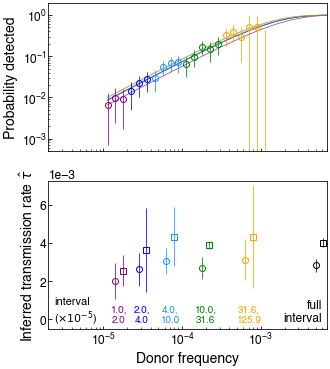

In [131]:
## donor frequency stratified
reload(shared)
t0, t1 = (14, 15)
recip_mouse = 6
donor_mice = [4,5]

detect_threshold = 0.5

# t0, t1 = (12,14)
# recip_mouse = 6
# donor_mice = [4,5]


reseq_large_indices = np.argsort(np.sum(shared.reseq_array, axis=0))[::-1][:1000]
reseq_large_bool = np.full(shared.reseq_array.shape[1], False)
reseq_large_bool[reseq_large_indices] = True
P1_bool = shared.barcode_pool_assignments['P1'][1] & (~reseq_large_bool)
P2_bool = shared.barcode_pool_assignments['P2'][1] & (~reseq_large_bool)


fig, axs = plt.subplots(2,1, figsize=(5, 6), sharex=True)
ax = axs[0]
ax2 = axs[1]
# for donor_windows, color in zip([(10**-5, 10**-4.5), (10**-4.5, 10**-4), (10**-4, 10**-3.5), (10**-3.5, 10**-3), (10**-3, 10**-2.5)],
#                                 ['purple', 'blue', 'orange', 'red', 'black', ]):

# backward_time_dict = shared.measure_transmission_in_interval(expt, recip_mouse, donor_mice, t0, t1, 
#                                                                 pool_assignment_bool=P2_bool, coarse_grain_num_groups=max_groups, 
#                                                                 min_barcodes=2, rescale_migration=rescale_migration, donor_freq_range=(0,1),
#                                                                 detect_threshold=detect_threshold) 

donor_floor, recip_floor_t0, recip_floor_t1 = backward_time_dict['freq floors']
m_detect, m_detect_err  = backward_time_dict['detected inference']
bins, density, errs, n_barcodes_per_bin = backward_time_dict['detected raw data']
tot_detected = density * n_barcodes_per_bin 
print("N barcodes detected:", np.sum(tot_detected[~np.isnan(tot_detected)]))
print( [f'{b:.2e}, {n_bc}' for b, n_bc in zip(bins, n_barcodes_per_bin)])
m_ratio, m_ratio_err = backward_time_dict['ratio inference']
(donor_valid, recip_valid, donor_cg, recip_cg) =  backward_time_dict['ratio raw data']

# ax.errorbar(bins, density, yerr=2*errs, markersize=12, ecolor='grey', fmt='.', mfc='none', mec='grey', label='Empirical')
# ax.plot(bins, shared.p_transmit(bins, m_detect/rescale_migration/recip_floor_t1), color='grey', label='Poisson fit', zorder=0, alpha=0.75)
ax2.errorbar(5*10**-3, y=m_detect, yerr=2*m_detect_err, markersize=6, ecolor='black', fmt='o', mfc='none', mec='black', label='Day')
ax2.errorbar(1.25*5*10**-3, y=m_ratio, yerr=2*m_ratio_err, markersize=6, ecolor='black', fmt='s', mfc='none', mec='black', label='Day')

# ax2.errorbar(1.25*10**-2, y=m_ratio, yerr=2*m_ratio_err, markersize=6, ecolor='grey', fmt='s', mfc='none', mec='grey', label='Empirical')

for donor_windows, color in zip([(10**-5, 10**-4.7), (10**-4.7, 10**-4.4), (10**-4.4, 10**-4.0), (10**-4.0, 10**-3.5), (10**-3.5, 10**-2.9)],
                                ['purple', 'blue', 'dodgerblue', 'green', 'orange', 'red', 'pink']):
        output_dict = shared.measure_transmission_in_interval(expt, recip_mouse, donor_mice, t0, t1, 
                                                                pool_assignment_bool=P2_bool, coarse_grain_num_groups=max_groups, 
                                                                min_barcodes=2, rescale_migration=rescale_migration, donor_freq_range=donor_windows,
                                                                detect_threshold=detect_threshold)         
        
        try:
                print(output_dict['detected inference'])
                print(output_dict['ratio inference'])

                donor_floor, recip_floor_t0, recip_floor_t1 = output_dict['freq floors']
                m_detect, m_detect_err  = output_dict['detected inference']
                bins, density, errs, n_barcodes_per_bin = output_dict['detected raw data']
                
                print( [f'{b:.2e}, {n_bc}' for b, n_bc in zip(bins, n_barcodes_per_bin)])
                m_ratio, m_ratio_err = output_dict['ratio inference']
                (donor_valid, recip_valid, donor_cg, recip_cg) =  output_dict['ratio raw data']

                ax.errorbar(bins, density, yerr=2*errs, markersize=12, ecolor=color, fmt='.', mfc='none', mec=color, label='Empirical')
                ax.plot(bins, shared.p_transmit(bins, m_detect/rescale_migration/recip_floor_t1), color=color, label='Poisson fit', zorder=0, alpha=0.75)
                ax2.errorbar(np.exp(np.mean(np.log(donor_windows))), y=m_detect, yerr=2*m_detect_err, markersize=6, ecolor=color, fmt='o', mfc='none', mec=color, label='Empirical')
                ax2.errorbar(np.exp(np.mean(np.log(donor_windows)))*1.25, y=m_ratio, yerr=2*m_ratio_err, markersize=6, ecolor=color, fmt='s', mfc='none', mec=color, label='Empirical')
                ax2.text(1.1*np.exp(np.mean(np.log(donor_windows))), -0.25e-3, f"{donor_windows[0]*10**5:.1f},\n{donor_windows[1]*10**5:.1f}", fontsize=10, ha='center', va='bottom', color=color)
        except:
                continue



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Probability detected', fontsize=14)
ax.set_xlim(2*10**-6, 7 * 10**-3)
ax.set_ylim(5*10**-4, 2)

ax2.set_xscale('log')
ax2.set_ylabel(r'Inferred transmission rate $\hat\tau$', fontsize=14)
ax2.set_xlabel('Donor frequency', fontsize=14)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax2.set_yscale('log')
ax2.set_ylim(-0.5e-3, ax2.get_ylim()[1])

ax2.text(0.98, 0.05, f'full\ninterval', ha='right', fontsize=12, transform=ax2.transAxes)
ax2.text(0.02, 0.05, f'interval\n'+r'($\times 10^{-5}$)', fontsize=11, transform=ax2.transAxes)

# for spine in ax.spines.values():
#         spine.set_linewidth(0.5)
# for spine in ax2.spines.values():
#         spine.set_linewidth(0.5)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_fig2B_stratified_m{recip_mouse}_t{t0}-{t1}.pdf', bbox_inches='tight', transparent=True, dpi=300)
fig.savefig(f'../figures/sfig_fig2B_stratified_m{recip_mouse}_t{t0}-{t1}.svg', bbox_inches='tight', transparent=True, dpi=300)
# legend 

141.075892207229


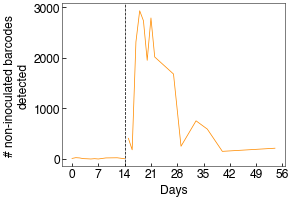

In [13]:
# detected at 15, probability detected at 14... 
reload(shared)

fig, ax = plt.subplots(1,1, figsize=(4, 3), sharex=True, gridspec_kw={'hspace': 0.2})


t0, t1 = (14, 15)
recip_mouse = 6
donor_mice = [4,5]

# for donor_windows, color in zip([(10**-5, 10**-4.7), (10**-4.7, 10**-4.4), (10**-4.4, 10**-4.0), (10**-4.0, 10**-3.5), (10**-3.5, 10**-3), (10**-3, 10**-2.5)],
#                                 ['black', 'purple', 'blue', 'dodgerblue', 'green', 'orange', 'red']):
reseq_large_indices = np.argsort(np.sum(shared.reseq_array, axis=0))[::-1][:300]
reseq_large_bool = np.full(shared.reseq_array.shape[1], False)
reseq_large_bool[reseq_large_indices] = True
P1_bool = shared.barcode_pool_assignments['P1'][1] & (~reseq_large_bool)
P2_bool = shared.barcode_pool_assignments['P2'][1] & (~reseq_large_bool)

# for mouse, barcode_pool_bool in zip([4,5,6,7], [P1_bool, P1_bool, P2_bool, P2_bool]):
for mouse, barcode_pool_bool in zip([6], [P2_bool]):
# for mouse, barcode_pool_bool in zip([6,7], [P2_bool, P2_bool]):
        mouse_days, mouse_reads, mouse_depths = shared.get_mouse_timecourse(expt, mouse, min_depth=10**3, include_reseq=True)
        mouse_freqs_non_inoculated = shared.calc_freqs(mouse_reads, mouse_depths)[:, barcode_pool_bool]
        mouse_reads_non_inoculated = mouse_reads[:, barcode_pool_bool]

        where_before_xc = np.where(mouse_days <= 14)[0][-1]

        window_before = np.where( (mouse_days > 8)*(mouse_days <= 14) )[0]
        window_after = np.where( (mouse_days > 14)*(mouse_days <= 20) )[0]
        
        # thresholded = np.einsum('ij,i->ij', mouse_freqs_non_inoculated, mouse_depths)

        threshold = detect_threshold
        ax.plot(mouse_days[:where_before_xc+1], (mouse_reads_non_inoculated > threshold).sum(axis=1)[:where_before_xc+1], color=mouse_colors[mouse], alpha=1, zorder=0)
        ax.plot(mouse_days[where_before_xc+1:], (mouse_reads_non_inoculated > threshold).sum(axis=1)[where_before_xc+1:], color=mouse_colors[mouse], label=f'{mouse}', alpha=1, zorder=0)
        
        median_before = np.median((mouse_reads_non_inoculated > threshold).sum(axis=1)[:where_before_xc+1]) * rnd.normal(1, 0.1)
        median_after = np.median((mouse_reads_non_inoculated > threshold).sum(axis=1)[where_before_xc+1:]) * rnd.normal(1, 0.1)
        print( median_after/median_before )

        # ax.plot( (0, 14), (median_before, median_before), color=mouse_colors[mouse], alpha=1, linestyle='dashed', lw=1.5)
        # ax.plot( (15, 55), (median_after, median_after), color=mouse_colors[mouse], alpha=1, linestyle='dashed', lw=1.5)


# ax.legend(loc=4, fontsize=10, title='Mouse', ncol=4, frameon=False, title_fontsize=12, columnspacing=0.5, handletextpad=0.2)

ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49, 56])
# ax.set_yscale('log')
ax.axvline(14, color='black', linestyle='dashed')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('# non-inoculated barcodes\ndetected', fontsize=12)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.set_xlabel('Days', fontsize=12)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_fig2B_numNonNative_barcodes_detected.pdf', transparent=True, dpi=300)
fig.savefig(f'../figures/sfig_fig2B_numNonNative_barcodes_detected.svg', transparent=True, dpi=300)

# ax.set_xlim(10, 17)


In [9]:
shared.library_array_map[('E1', 3, 6)]

[('vivo', 57), ('reseq', 33)]

Real (day 14->12): 2.83e-03 +/- 1.42e-04
['1.13e-05, 760', '1.42e-05, 736', '1.79e-05, 676', '2.25e-05, 634', '2.84e-05, 631', '3.57e-05, 536', '4.50e-05, 437', '5.66e-05, 413', '7.13e-05, 353', '8.97e-05, 284', '1.13e-04, 236', '1.42e-04, 185', '1.79e-04, 154', '2.25e-04, 87', '2.84e-04, 70', '3.57e-04, 40', '4.50e-04, 31', '5.66e-04, 17', '7.13e-04, 4', '8.97e-04, 4', '1.13e-03, 2', '1.42e-03, 0', '1.79e-03, 0', '2.25e-03, 0', '2.84e-03, 0', '3.57e-03, 0', '4.50e-03, 0', '5.66e-03, 0', '7.13e-03, 0', '8.97e-03, 0', '1.13e-02, 0', '1.42e-02, 0', '1.79e-02, 0', '2.25e-02, 0', '2.84e-02, 0', '3.57e-02, 0', '4.50e-02, 0', '5.66e-02, 0', '7.13e-02, 0', '8.97e-02, 0', '1.13e-01, 0', '1.42e-01, 0', '1.79e-01, 0', '2.25e-01, 0', '2.84e-01, 0', '3.57e-01, 0', '4.50e-01, 0', '5.66e-01, 0', '7.13e-01, 0', '8.97e-01, 0']
Null (day 14->12): 6.55e-05 +/- 2.48e-05
0.0028314039883718936 0.00016880739568002847


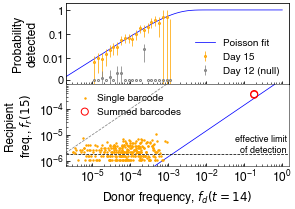

In [84]:
# main fig example 
reload(shared)
recipient_mouse = 6
t0, t1 = 14, 15

example_transmission = transmission_dict[recipient_mouse][(t0, t1)]

donor_floor, recip_floor_t0, recip_floor_t1 = example_transmission['freq floors']
m_detect, m_detect_err  = example_transmission['detected inference']
bins, density, errs, n_barcodes_per_bin = example_transmission['detected raw data']
print(f"Real (day 14->12): {m_detect:.2e} +/- {m_detect_null:.2e}")
print( [f'{b:.2e}, {n_bc}' for b, n_bc in zip(bins, n_barcodes_per_bin)])

m_ratio, m_ratio_err = example_transmission['ratio inference']
(donor_valid, recip_valid, donor_cg, recip_cg) =  example_transmission['ratio raw data']


plot_fig, plot_axs = plt.subplots(2, 1, figsize=(4,3))
plt.subplots_adjust(hspace=0.00)
detected_ax = plot_axs[0]


## NULL
null_transmission = backward_time_dict # 14->12
m_detect_null, m_detect_err_null  = null_transmission['detected inference']
# m_ratio_null, m_ratio_err_null = null_transmission['ratio inference']
null_bins, null_density, null_errs, null_n_barcodes_per_bin = np.copy(null_transmission['detected raw data'])
print(f"Null (day 14->12): {m_detect_null:.2e} +/- {m_detect_err_null:.2e}")
# print(null_density)
# null_density[null_density == 0] = 1/(2*null_n_barcodes_per_bin[null_density == 0])
null_errs[null_density == 0] = 0
null_density[null_density == 0] = 1.25*10**-3
# null_errs[null_density == 0] = 0
# detected_ax.set_ylim(detected_ax.get_ylim()[0]/2, 2)
####

detected_ax.errorbar(bins, density, yerr=2*errs, markersize=2, ecolor='orange', fmt='o', mfc='none', mec='orange', label='Day 15')
detected_ax.plot(np.logspace(-6, 0, 61), shared.p_transmit(np.logspace(-6, 0, 61), m_detect/rescale_migration/recip_floor_t1), color='blue', label='Poisson fit', zorder=0)
detected_ax.errorbar(null_bins, null_density, yerr=null_errs, markersize=2, ecolor='grey', fmt='o', mfc='none', mec='grey', label='Day 12 (null)')
detected_ax.set_xscale('log')
detected_ax.set_yscale('log')
detected_ax.set_ylabel('Probability\ndetected', fontsize=12)

# detected_ax.set_ylim(10**-3, 2)

detected_ax.set_xticklabels([])
detected_ax.legend(loc=4, fontsize=10, frameon=False)

ratio_ax = plot_axs[1]
ratio_ax.scatter(donor_valid, recip_valid, s=2, color='orange', rasterized=True, label='Single barcode')
ratio_ax.scatter(donor_cg, recip_cg, s=50, marker='o', facecolor='none', edgecolors='red', rasterized=True, label='Summed barcodes')

rescale_migration = 2
ratio_ax.axline((10**-5, m_detect/rescale_migration*10**-5), (1, m_detect/rescale_migration), color='blue', zorder=0)
print(m_detect, m_detect_err)
util.plot_diagonal(ratio_ax, color='grey')
ratio_ax.set_xscale('log')
ratio_ax.set_yscale('log')

ratio_ax.set_xlim(2*10**-6, 1.5)
detected_ax.set_xlim(2*10**-6, 1.5)
detected_ax.set_ylim(8*10**-4, 2)
detected_ax.set_yticks([1.25*10**-3, 10**-2, 10**-1, 1])
detected_ax.set_yticklabels([0, 10**-2, 10**-1, 1], fontsize=11)

# detected_ax.text(0.75*10**-4, 2*10**-3, "undetected", color='grey', fontsize=7.5)



ratio_ax.set_ylim(10**-6.2, 9*10**-4)
ratio_ax.set_xlabel(r'Donor frequency, $f_d(t=14)$', fontsize=12)
ratio_ax.set_ylabel('Recipient\nfreq., $f_r(15)$', fontsize=12)
ratio_ax.legend(loc=2, fontsize=10, frameon=False, handletextpad=0.2)
for spine in ['top', 'right', 'bottom', 'left']:
    ratio_ax.spines[spine].set_linewidth(0.5)

ratio_ax.axhline(recip_floor_t1, color='black', linestyle='dashed', zorder=0)
ratio_ax.text(0.99, 0.172, 'effective limit\nof detection', transform=ratio_ax.transAxes, color='black', fontsize=9, ha='right')

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(f'../figures/single_day_transmission_plot_M{recipient_mouse}_{t0}_{t1}.pdf', bbox_inches='tight', transparent=True)
plt.savefig(f'../figures/single_day_transmission_plot_M{recipient_mouse}_{t0}_{t1}.svg', bbox_inches='tight', transparent=True)

4 27 29
t1 large 29
4 33 36
t1 large 36
5 27 29
t1 large 29
5 33 36
t1 large 36
6 27 29
t1 large 29
6 33 36
t1 large 36
7 27 29
t1 large 29
7 33 36
t1 large 36


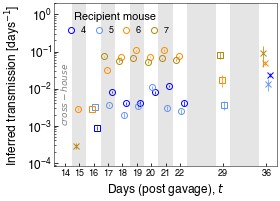

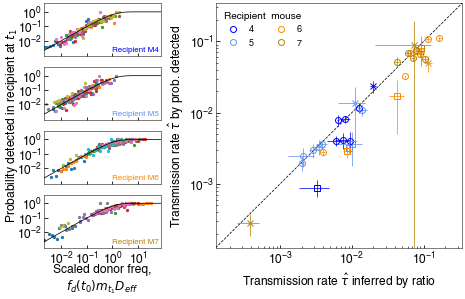

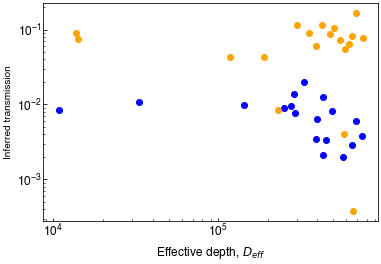

In [135]:
main_fig = plt.figure(figsize=(4, 3))
outer = mpl.gridspec.GridSpec(nrows=1, ncols=1, figure=main_fig)
outer_ax = main_fig.add_subplot(outer[:])
outer_ax.set_xlabel(r'Days (post gavage), $t$', fontsize=12)
outer_ax.set_ylabel("Inferred transmission [days$^{-1}$]", fontsize=12)

si_fig = plt.figure(figsize=(7.5, 4.5))
gs = plt.GridSpec(nrows = 4, ncols = 2, width_ratios=(1, 2.1), wspace=0.3, figure=si_fig)

compare_ax = si_fig.add_subplot(gs[:, 1])
outer_detect_ax = si_fig.add_subplot(gs[:, 0])
util.turn_off_ax(outer_detect_ax)
outer_detect_ax.set_ylabel('Probability detected in recipient at $t_1$', fontsize=12, labelpad=24)
outer_detect_ax.set_xlabel(r'Scaled donor freq,' +'\n' + r'$f_d(t_0)m_{t_1} D_{eff}$', fontsize=12, labelpad=15)

x, y = [], []

filtered_transmission_measures = {(expt, mouse):{'detect': [], 'ratio':[]} for mouse in transmission_dict.keys()}

fig, depth_ax = plt.subplots()
for r, recipient_m in enumerate([4,5,6,7]):
    transmission_measurements = transmission_dict[recipient_m]

    color = mouse_colors[recipient_m]

    detected_ax = si_fig.add_subplot(gs[r, 0])
    detected_ax.text(0.98, 0.05, f'Recipient M{recipient_m}', transform=detected_ax.transAxes, fontsize=8, ha='right', va='bottom', color=mouse_colors[recipient_m])
  
    for (t0, t1), measurements in transmission_measurements.items():
        if t1 <= 14 or measurements is None:
            continue
        if t1-t0 > 4:
            continue
        elif t1-t0 == 2 and (t0+1, t1) in transmission_measurements:
            continue
        elif t1-t0 == 3 and ((t0+1, t1) in transmission_measurements or (t0+2, t1) in transmission_measurements):
            continue
        elif t1-t0 == 4 and ((t0+1, t1) in transmission_measurements \
                             or (t0+2, t1) in transmission_measurements \
                                or (t0+3, t1) in transmission_measurements):
            continue
        
        # sampled_days.add(t1)
        if t1-t0 == 1:
            fmt = 'o'
        elif t1-t0 == 2:
            fmt = 's'
        elif t1-t0 == 3:
            fmt = 'x'
        elif t1-t0 == 4:
            fmt = '^'

        if t1 > 25:
            print(recipient_m, t0, t1)

        if t1 >= 18:
            filtered_transmission_measures[(expt, recipient_m)]['ratio'].append(m_ratio)
            filtered_transmission_measures[(expt, recipient_m)]['detect'].append(m_detect)
        # if t1 > 25:
        #     print('t1 large', t1)
        #     t1 = 24 # for plotting

        if t1 == 29:
            print('t1 large', t1)
            t1 = 25 # for plotting
        if t1 == 36:
            print('t1 large', t1)
            t1 = 28 # for plotting

        
    
        donor_floor, recip_floor_t0, recip_floor_t1 = measurements['freq floors']
        m_detect, m_detect_err  = measurements['detected inference']
        bins, density,errs, n_bc_per_bin = measurements['detected raw data']

        detected_ax.scatter(bins * m_detect / rescale_migration * recip_floor_t1**-1., density, s=5)        
        detected_ax.set_xscale('log')
        detected_ax.set_yscale('log')


        m_ratio, m_ratio_err = measurements['ratio inference']

        compare_ax.errorbar(m_ratio, m_detect, xerr=2*m_ratio_err, yerr=2*m_detect_err, color=mouse_colors[recipient_m], mfc='none', fmt=fmt)

        c = 'blue' if recipient_m in [4,5] else 'orange'
        depth_ax.scatter( recip_floor_t1**-1., m_ratio, color=c )
        x.append(recip_floor_t1**-1.)
        y.append(m_detect)

        # outer_ax.scatter(t1, m_ratio)
        # outer_ax.errorbar([t1-(r-1.5)/6], m_ratio, yerr=m_ratio_err, color=color, mfc='none', fmt=fmt)
        outer_ax.errorbar([t1-(r-1.5)/6], m_detect, yerr=m_detect_err, color=color, mfc='none', fmt=fmt)
        


    detected_ax.plot(np.logspace(-3, 2, 101), 1-np.exp(-np.logspace(-3,2, 101)), color='black') #theory poisson
    detected_ax.set_xlim(2*10**-3, 80)
    detected_ax.set_ylim(8*10**-4, 4)
    detected_ax.set_xticks([10**-2, 10**-1, 10**0, 10])
    detected_ax.set_yticks([10**-2, 10**-1, 10**0])
    for spine in ['top', 'right', 'left', 'bottom']:
        detected_ax.spines[spine].set_linewidth(0.5)
    if r != 3:
        detected_ax.set_xticklabels([])

# format si fig
compare_ax.set_xscale('log')
compare_ax.set_yscale('log')
compare_ax.set_xlabel(r'Transmission rate $\hat{\tau}$ inferred by ratio', fontsize=12)
compare_ax.set_ylabel(r'Transmission rate $\hat{\tau}$ by prob. detected', fontsize=12)
util.plot_diagonal(compare_ax)

legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', lw=0, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
compare_ax.legend(legend_markers, [4,5,6,7], title='Recipient  mouse', ncol=2, loc=2, title_fontsize=10, fontsize=9, frameon=False)


for ax in [outer_ax, compare_ax, detected_ax]:
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_linewidth(0.5)



### 
depth_ax.set_xscale('log')
depth_ax.set_yscale('log')

notnan = ~np.isnan(y) & (np.array(x) > 3*10**3)
# print(scipy.stats.pearsonr(np.log(x)[notnan], np.log(y)[notnan]))

# format main fig
legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', lw=0, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
outer_ax.legend(legend_markers, [4,5,6,7], title='Recipient mouse', ncol=4, loc=2, title_fontsize=11, fontsize=9, frameon=False, columnspacing=0.4, handletextpad=0.1)
outer_ax.set_yscale('log')
outer_ax.tick_params(axis='y', labelsize=12)
outer_ax.tick_params(axis='x', labelsize=9)

outer_ax.text(14, 10**-3, "$\it{cross-house}$", rotation=90, ha='center', va='bottom', fontsize=9, color='grey')
outer_ax.set_xticks( list(np.arange(14,23)) + [25, 28])
outer_ax.set_xticklabels( [f'{e+14}' for e in np.arange(14, 23) - 14] + [29, 36] )
for i in np.arange(14.5, 22.5, 2):
    outer_ax.axvspan(i, i+1, color='grey', alpha=0.2, zorder=0,lw=0)
outer_ax.axvspan(22.5, 24.5, color='grey', alpha=0.2, zorder=0, lw=0)
outer_ax.axvspan(25.5, 27.5, color='grey', alpha=0.2, zorder=0, lw=0)
outer_ax.set_xlim(13.25, 28.75)
outer_ax.set_ylim(8*10**-5, 2*10**0)
# outer_ax.text(0.65, 0.85, 'High influx', transform=outer_ax.transAxes, fontsize=14, color='sienna', ha='left')
# outer_ax.text(0.65, 0.1, 'Low influx', transform=outer_ax.transAxes, fontsize=14, color='navy', ha='left')
# outer_ax.text(0.65, 0.85, 'High influx', transform=outer_ax.transAxes, fontsize=14, color='sienna', ha='left')
# outer_ax.text(0.65, 0.1, 'Low influx', transform=outer_ax.transAxes, fontsize=14, color='navy', ha='left')

plt.rcParams['svg.fonttype'] = 'none'
main_fig.savefig(f'../figures/migration_figB_transmission_over_time.pdf', transparent=True, bbox_inches='tight')
si_fig.savefig(f'../figures/sfig_monocolonization_transmission_consistency.pdf', transparent=True, bbox_inches='tight')

main_fig.savefig(f'../figures/migration_figB_transmission_over_time.svg', transparent=True, bbox_inches='tight')
si_fig.savefig(f'../figures/sfig_monocolonization_transmission_consistency.svg', transparent=True, bbox_inches='tight')

depth_ax.set_xlabel('Effective depth, $D_{eff}$', fontsize=12)
depth_ax.set_ylabel('Inferred transmission')

avg_transmission_measures = {}

for expt, mouse in [('E1', 4), ('E1', 5), ('E1', 6), ('E1', 7)]:
    ratio = np.array(filtered_transmission_measures[(expt, mouse)]['ratio'])
    detect = np.array(filtered_transmission_measures[(expt, mouse)]['detect'])


    mean_ratio = np.mean(filtered_transmission_measures[(expt, mouse)]['ratio'])
    mean_logratio = np.exp(np.mean(np.log(filtered_transmission_measures[(expt, mouse)]['ratio'])))

    mean_detect = np.mean(detect[~np.isnan(detect)])
    mean_logdetect = np.exp(np.mean(np.log(detect[~np.isnan(detect)])))
    

    avg_transmission_measures[ (expt, mouse) ] = {'ratio':mean_ratio, 'log_ratio':mean_logratio, 'detect':mean_detect, 'log_detect':mean_logdetect}

Example barcodes

E AGACGACAATATCCACTTTC 0.00518007008956294
2
2
F TCCGTTAACCTTCATAGTTG 0.0472886064543283
2
2
G CGGTTGCGGTATTACAAGTC 0.018101814975401934
2
2
H ATTAACCGTTGACCGCTGCT 0.00342216767336169
2
2
I TGTAGTAGGCATAATAACCC 0.0017287177372974942
2
2
J AACTACTCTTTGCATTTCCG 0.0020883457852771316
2
2


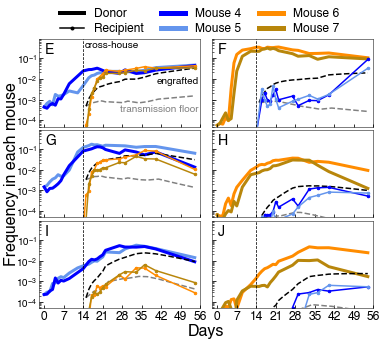

In [85]:
reload(shared)
expt = 'E1'
mouse_colors = {6:'darkorange', 7:'darkgoldenrod', 4:'blue', 5:'cornflowerblue'}

example_barcodes = {
    # BARCODE: (DONOR, COLOR, ROW, COL)
    'AGACGACAATATCCACTTTC': ([5, 4], 'lightblue', 0, 0, 'E'),
    'TCCGTTAACCTTCATAGTTG':([6, 7], 'gold', 0, 1, 'F'),
    'CGGTTGCGGTATTACAAGTC': ([5, 4], 'lightblue', 1, 0, 'G'),
    'ATTAACCGTTGACCGCTGCT': ([6, 7], 'gold', 1, 1, 'H'),
    'TGTAGTAGGCATAATAACCC': ([5, 4], 'lightblue', 2, 0, 'I'),
    # 'CCGTTACATGCGTTCTTGGT': ([5, 4], 'lightblue', 2, 0, 'I'),
    'AACTACTCTTTGCATTTCCG': ([6, 7], 'gold', 2, 1, 'J')}


# transmission_averages ={4:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
#                         5:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
#                         6:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,
#                         7:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,}

transmission_averages ={4:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
                        5:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
                        6:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,
                        7:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,}

# transmission_averages ={4:(avg_transmission_measures[(expt, 4)]['log_detect'] + avg_transmission_measures[(expt, 5)]['log_detect'])/2,
#                         5:(avg_transmission_measures[(expt, 4)]['log_detect'] + avg_transmission_measures[(expt, 5)]['log_detect'])/2,
#                         6:(avg_transmission_measures[(expt, 6)]['log_detect'] + avg_transmission_measures[(expt, 7)]['log_detect'])/2,
#                         7:(avg_transmission_measures[(expt, 6)]['log_detect'] + avg_transmission_measures[(expt, 7)]['log_detect'])/2,}

# transmission_averages ={4:(avg_transmission_measures[(expt, 4)]['ratio'] + avg_transmission_measures[(expt, 5)]['ratio'])/2,
#                         5:(avg_transmission_measures[(expt, 4)]['ratio'] + avg_transmission_measures[(expt, 5)]['ratio'])/2,
#                         6:(avg_transmission_measures[(expt, 6)]['ratio'] + avg_transmission_measures[(expt, 7)]['ratio'])/2,
#                         7:(avg_transmission_measures[(expt, 6)]['ratio'] + avg_transmission_measures[(expt, 7)]['ratio'])/2,}


panel_numbers = {(0,0):'E',
                 (0,1):'F',
                 (1,0):'G',
                 (1,1):'H',
                 (2,0):'I',
                 (2,1):'J'}

donor_recipient_map = {4:[6,7], 5:[6,7], 6:[4,5], 7:[4,5]}

fig = plt.figure(figsize=(6,5.5))
gs = plt.GridSpec(4,2, figure=fig, height_ratios = [0.3, 1,1,1], wspace=0.07, hspace=0.05)
outer_upper = fig.add_subplot(gs[2, :])
outer_lower = fig.add_subplot(gs[-1, :])
util.turn_off_ax(outer_upper)
util.turn_off_ax(outer_lower)
outer_lower.set_xlabel('Days', fontsize=16, labelpad=15)
outer_upper.set_ylabel('Frequency in each mouse', labelpad=20, fontsize=16)

legend_ax = fig.add_subplot(gs[0, :])
util.turn_off_ax(legend_ax)
legend_markers = [mpl.lines.Line2D((0,0), (0,0), lw=4, color='black'), mpl.lines.Line2D((0,0), (0,0), lw=1.5, marker='.', color='black')] +\
    [mpl.lines.Line2D((0,0), (0,0), lw=5, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
legend_ax.legend(legend_markers, ['Donor', 'Recipient', 'Mouse 4', 'Mouse 5', 'Mouse 6', 'Mouse 7'], loc=(0.05, -0.15), ncol=3, columnspacing=1.5, labelspacing=0.25, fontsize=12, frameon=False)


for barcode, (donors, color, row, col, panel) in example_barcodes.items():
    barcode_idx = np.where(shared.barcodes == barcode)[0][0]
    barcode_totfreq = np.sum(shared.reseq_array[:, barcode_idx]) / shared.reseq_array.sum()
    print(panel, barcode, barcode_totfreq)


    recipients = donor_recipient_map[donors[0]]
    freq_ax = fig.add_subplot(gs[row+1, col])

    init_day = 14
    shared.plot_barcode_trajectories(freq_ax, barcode, expt, donors, recipients, transmission_averages, mouse_colors, init_day, plot_other_donors=True)

    freq_ax.set_yscale('log')
    freq_ax.set_yticks([10**-4, 10**-3, 10**-2, 10**-1, 1])
    freq_ax.set_ylim(5*10**-5, 8 * 10**-1)
    freq_ax.axvline(14, color='black', linestyle='dashed')
    freq_ax.set_xticks([0,7,14, 21, 28, 35, 42, 49, 56])
    freq_ax.set_xticklabels([0,7, 14, 21, 28, 35, 42, 49, 56], fontsize=12)
    freq_ax.set_xlim(-2, 56)
    freq_ax.yaxis.set_tick_params(labelsize=10)

    # freq_ax.set_xlim(0, 10)

    freq_ax.text(0.04, 0.84, panel, transform=freq_ax.transAxes, fontsize=14, weight='heavy')
    if row == 0 and col == 0:
        freq_ax.text(0.99, 0.25, 'transmission floor', fontsize=10, color='grey',
                     ha='right', va='top', transform=freq_ax.transAxes)
        freq_ax.text(0.99, 0.58, 'engrafted', fontsize=10, color='black',
                     ha='right', va='top', transform=freq_ax.transAxes)

    #make spines 0.5
    freq_ax.spines['top'].set_linewidth(0.5)
    freq_ax.spines['right'].set_linewidth(0.5)
    freq_ax.spines['bottom'].set_linewidth(0.5)
    freq_ax.spines['left'].set_linewidth(0.5)

    if row!=2:
        freq_ax.set_xticklabels([])
    if col!=0:
        freq_ax.set_yticklabels([])
    
    if (row == 0) & (col == 0):
        freq_ax.text(14.5, 0.7, 'cross-house', ha='left', va='top', fontsize=10, color='black', rotation=0)


plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig2_example_engrafted_barcodes.svg', bbox_inches='tight', transparent=True, dpi=300)
fig.savefig(f'../figures/fig2_example_engrafted_barcodes.pdf', transparent=True, bbox_inches='tight')

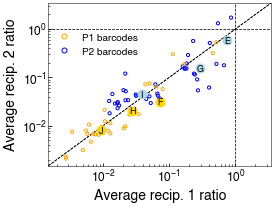

In [86]:
# overlap_days_map = {}
# for m1 in [4,5,6,7]:
#     # m1_days, m1_rows = shared.mouse_meta['E1'][m1][:2]
#     m1_days, _, _ = shared.get_mouse_timecourse('E1', m1, min_depth=10**4)
#     m1_days = np.array(m1_days)
#     for m2 in [4,5,6,7]:
#         m2_days, m2_rows = shared.mouse_meta['E1'][m2][:2]
#         m2_days = np.array(m2_days)

#         m1m2_overlap = []
#         m1_sub_rows = []
#         m2_sub_rows = []

#         for i, m2_day in enumerate(m2_days[::-1]):
#             z = np.where(m1_days <= m2_day)[0][-1]
#             m1_day = m1_days[z]

#             if m2_day - m1_day <= 1:
#                 m1m2_overlap.append( m2_day )
#                 m1_sub_rows.append(z)
#                 m2_sub_rows.append(len(m2_days)-1-i)
#             else:
#                 continue


#         overlap_days_map[(m1,m2)] = [np.array(m1m2_overlap[::-1]),
#                                      np.array(m1_sub_rows[::-1]),
#                                      np.array(m2_sub_rows[::-1])]
overlap_days_map = {}
for m1 in [4,5,6,7]:
    # m1_days, m1_rows = shared.mouse_meta['E1'][m1][:2]
    # m1_days = np.array(m1_days)
    m1_days, _, _ = shared.get_mouse_timecourse('E1', m1, min_depth=10**4)
    
    for m2 in [4,5,6,7]:
        # m2_days, m2_rows = shared.mouse_meta['E1'][m2][:2]
        # m2_days = np.array(m2_days)
        m2_days, _, _ = shared.get_mouse_timecourse('E1', m2, min_depth=10**4)

        m1m2_overlap = []
        m1_sub_rows = []
        m2_sub_rows = []

        m1_overlap_days = []
        m2_overlap_days = []

        for i, m2_day in enumerate(m2_days[::-1]):
            z = np.where(m1_days <= m2_day)[0][-1]
            m1_day = m1_days[z]

            if m2_day - m1_day <= 1:
                m1_overlap_days.append(m1_day)
                m2_overlap_days.append(m2_day)

                # m1m2_overlap.append( m2_day )
                # m1_sub_rows.append(z)
                # m2_sub_rows.append(len(m2_days)-1-i)
            else:
                continue
        overlap_days_map[(m1,m2)] = [m1_overlap_days, m2_overlap_days]

        # overlap_days_map[(m1,m2)] = [np.array(m1m2_overlap[::-1]),
        #                              np.array(m1_sub_rows[::-1]),
        #                              np.array(m2_sub_rows[::-1])]


expt = 'E1'
# mice_days = [shared.mouse_meta['E1'][mouse][0] for mouse in [4,5]]
fig, ax = plt.subplots(figsize=(4,3))
cutoff = 10**-2

P1_barcode_indices, P2_barcode_indices= shared.barcode_pool_assignments['P1'][0], shared.barcode_pool_assignments['P2'][0]

large_barcode_migration_ratios = {}
for (donors, recips, donor_barcode_indices, color) in [ [[4,5], [6,7], P2_barcode_indices, 'blue'], [[6,7], [4,5], P1_barcode_indices, 'orange']]:
    donor1, donor2 = donors
    recip1, recip2 = recips


    donor1_overlap_days, donor2_overlap_days = overlap_days_map[(donor1,donor2)]
    # donor_overlap_days, m1_indices, m2_indices = overlap_days_map[(donor1,donor2)]

    donor1_days, donor1_reads, donor1_depths = shared.get_mouse_timecourse(expt, donor1, min_depth=10**4)
    donor1_freqs = shared.calc_freqs(donor1_reads, donor1_depths)

    donor2_days, donor2_reads, donor2_depths = shared.get_mouse_timecourse(expt, donor2, min_depth=10**4)
    donor2_freqs = shared.calc_freqs(donor2_reads, donor2_depths)
    
    recip1_days, recip1_reads, recip1_depths = shared.get_mouse_timecourse(expt, recip1, min_depth=10**4)
    recip1_freqs = shared.calc_freqs(recip1_reads, recip1_depths)

    recip2_days, recip2_reads, recip2_depths = shared.get_mouse_timecourse(expt, recip2, min_depth=10**4)
    recip2_freqs = shared.calc_freqs(recip2_reads, recip2_depths)


    x_lst = [ [], [] ]
    included_indices = []
    included_donor_freqs = [[],[]]
    for i in donor_barcode_indices:
        barcode = shared.barcodes[i]
        if np.max(donor1_freqs[:, i]) < cutoff and np.max(donor2_freqs[:, i]) < cutoff: #focus on large barcodes
            continue

        interp1_days, interp1_freqs = shared.calc_interpolated_freqs((donor1_days, donor1_freqs[:,i]), Deff_array=donor1_depths)
        interp2_days, interp2_freqs = shared.calc_interpolated_freqs((donor2_days, donor2_freqs[:,i]), Deff_array=donor2_depths)
        donor_avg_freqs = np.mean([interp1_freqs, interp2_freqs], axis=0)

        included_indices.append(i)

        recip_ratios = []

        for r, (recip, recip_days, recip_freqs, recip_depths) in enumerate(zip([recip1, recip2], 
                                                                               [recip1_days, recip2_days], 
                                                                               [recip1_freqs[:, i], recip2_freqs[:, i]], 
                                                                               [recip1_depths, recip2_depths])):
            

            # donor_overlap_days, recip_overlap_days = overlap_days_map[(donor, recip)]

            where_overlap_donor = np.array([(day in recip_days) and day > 14 for day in interp1_days])
            where_overlap_recip = np.array([day > 14 for day in recip_days])
            
            recip_floors = 1/recip_depths

            # past_xhouse = (overlap_days > 14)*where_overlap #* (donor_freqs[d_indices] > 0)
            shared_donor_freqs = donor_avg_freqs[where_overlap_donor]
            nonzero = shared_donor_freqs >= 0
            shared_donor_freqs = shared_donor_freqs[nonzero]

            shared_recip_freqs = recip_freqs[where_overlap_recip][nonzero]
            shared_recip_floors = recip_floors[where_overlap_recip][nonzero]
            shared_recip_freqs[shared_recip_freqs == 0] = shared_recip_floors[shared_recip_freqs == 0]


            ratio = np.mean(shared_recip_freqs / shared_donor_freqs)
            x_lst[r].append(ratio)
            recip_ratios.append((recip, ratio))

        large_barcode_migration_ratios[i] = {'donor':donor1, 'recips':recip_ratios}

    discovery = np.array(x_lst[0])
    validation = np.array(x_lst[1])
    sorting = np.argsort(discovery)[::-1]
    ax.scatter(discovery, validation, s=10, facecolors='none', edgecolors=color)

    for i, idx in enumerate(included_indices):
        barcode = shared.barcodes[idx]
        if barcode in example_barcodes.keys():
            donors, color, row, col, panel = example_barcodes[barcode]

            ax.scatter(discovery[i], validation[i], marker='o', s=80, color=color)
            ax.text(discovery[i], validation[i], panel, fontsize=9, color='black',
                    ha='center', va='center')

    util.plot_diagonal(ax)


with open(f'{data_dir}/pickled/E1_large_barcode_migration_ratios.pkl', 'wb') as f:
    pickle.dump(large_barcode_migration_ratios, f)


legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', mfc='none', mec=col, markersize=5, lw=0) for col in ['orange', 'blue']]
ax.legend(legend_markers, ['P1 barcodes', 'P2 barcodes'], loc=(0.01, 0.65), fontsize=10, frameon=False, bbox_transform=ax.transAxes)

ax.set_xlabel('Average recip. 1 ratio', fontsize=14)
ax.set_ylabel('Average recip. 2 ratio', fontsize=14)
# ax.text(0.35, 0.15, 'Transient', fontsize=12, transform=ax.transAxes, color='grey')
# ax.text(0.81, 0.92, 'Engrafted', fontsize=12, transform=ax.transAxes, color='black', ha='right')
# ax.set_xlim(8*10**-4, 2.5)
# ax.set_ylim(8*10**-4, 2.5)

ax.set_xlim(1.5*10**-3, 3.5)
ax.set_ylim(1.5*10**-3, 3.5)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(0.5)
    

ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1, color='black', linestyle='dashed', zorder=0)
ax.axhline(1, color='black', linestyle='dashed', zorder=0)


plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig2_mono_transmission_recip1_v_recip2.svg', bbox_inches='tight', transparent=True, dpi=300)
fig.savefig(f'../figures/fig2_mono_transmission_recip1_v_recip2.pdf', transparent=True, bbox_inches='tight')


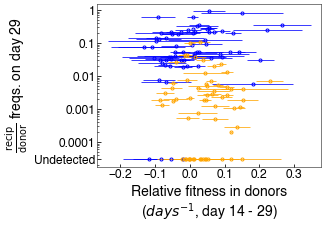

In [87]:
expt = 'E1'

## plot recipient/donor ratio vs growth rate in donor...
t_init, t_final = 14, 29
mouse_init_t = {4:14, 5:14, 6:14, 7:18} 
mouse_final_t = {4:t_final, 5:t_final, 6:t_final, 7:t_final}


fig, ax = plt.subplots(figsize=(4,3))

ref_barcodes = {25:'navy', 0:'peru',11:'blue',
                       37:'darkorange', 36:'lightblue', 41:'gold'}
large_barcode_migration_ratios = {}

for (donors, recips, (inoc_barcodes, inoc_bool), color) in [ [[4, 5], [6,7], shared.barcode_pool_assignments['P2'], 'blue'], 
                                                            [[6, 7], [4,5], shared.barcode_pool_assignments['P1'], 'orange']]:
    d1_days, d1_reads, d1_depths = shared.get_mouse_timecourse(expt, donors[0], min_depth=10**4, specific_timepoints=(mouse_init_t[donors[0]], mouse_final_t[donors[0]]))   
    d2_days, d2_reads, d2_depths = shared.get_mouse_timecourse(expt, donors[1], min_depth=10**4, specific_timepoints=(mouse_init_t[donors[1]], mouse_final_t[donors[1]]))

    r1_days, r1_reads, r1_depths = shared.get_mouse_timecourse(expt, recips[0], min_depth=10**4, specific_timepoints=(mouse_init_t[recips[0]], mouse_final_t[recips[0]]))
    r2_days, r2_reads, r2_depths = shared.get_mouse_timecourse(expt, recips[1], min_depth=10**4, specific_timepoints=(mouse_init_t[recips[1]], mouse_final_t[recips[1]]))

    d1_freqs = shared.calc_freqs(d1_reads, d1_depths)
    d2_freqs = shared.calc_freqs(d2_reads, d2_depths)

    r1_freqs = shared.calc_freqs(r1_reads, r1_depths)
    r2_freqs = shared.calc_freqs(r2_reads, r2_depths)

    donor_init = np.array([d1_freqs[0, :], d2_freqs[0, :]])
    donor_final = np.array([d1_freqs[1, :], d2_freqs[1, :]])
    donor_D0 = np.array([d1_depths[0], d2_depths[0]])
    donor_D1 = np.array([d1_depths[1], d2_depths[1]])

    recip_init = np.array([r1_freqs[0, :], r2_freqs[0, :]])
    recip_final = np.array([r1_freqs[1, :], r2_freqs[1, :]])
    recip_D0 = np.array([r1_depths[0], r2_depths[0]])
    recip_D1 = np.array([r1_depths[1], r2_depths[1]])

    donor_dt = np.array( [mouse_final_t[donor] - mouse_init_t[donor] for donor in donors] )
    recip_dt = np.array( [mouse_final_t[recip] - mouse_init_t[recip] for recip in recips] )

    
    # d1_freqs = shared.freq_array[ shared.mouse_meta[expt][donors[0]][1], :]
    # d2_freqs = shared.freq_array[ shared.mouse_meta[expt][donors[1]][1], :]

    # donor_init = shared.freq_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors], :]
    # donor_Dinit = shared.Deff_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors]]

    # donor_final = shared.freq_array[ [shared.vivo_row_ids[(expt, donor, mouse_final_t[donor])] for donor in donors], :]
    # donor_Dfinal = shared.Deff_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors]]
    # donor_dt = np.array( [mouse_final_t[donor] - mouse_init_t[donor] for donor in donors] )

    # recip_init = shared.freq_array[ [shared.vivo_row_ids[(expt, recip, mouse_init_t[recip])] for recip in recips], :]
    # recip_final = shared.freq_array[ [shared.vivo_row_ids[(expt, recip, mouse_final_t[recip])] for recip in recips], :]
    # recip_dt = np.array( [mouse_final_t[recip] - mouse_init_t[recip] for recip in recips] )

    ## calculate growth rates
    x_lst = [ [], [] ]

    for i, barcode in enumerate(shared.barcodes):
        if ~inoc_bool[i]:
            continue

        if np.max( np.min([donor_init[:, i], donor_final[:, i]], axis=0) ) < 1e-3:
            continue
        
        donor_growth = []
        for (f0, f1, D0, D1, dt) in zip(donor_init, donor_final, donor_D0, donor_D1, donor_dt):
            f0, f1 = shared.maxmin_freqs([f0[i]], D0, [f1[i]], D1)
            fitness = np.log(f1/f0) / dt
            donor_growth.append(fitness[0])
        donor_growth = np.array(donor_growth)

        with np.errstate(divide='ignore'):
            recip_donor_ratio = recip_final[:, i] / np.mean(donor_final[:, i])
            recip_donor_ratio[recip_donor_ratio == 0] = 3e-5
        xerr = [[np.mean(donor_growth) - np.min(donor_growth)], [np.max(donor_growth) - np.mean(donor_growth)]]

        yerr = [[np.mean(recip_donor_ratio) - np.min(recip_donor_ratio)], [np.max(recip_donor_ratio) - np.mean(recip_donor_ratio)]]

        ax.errorbar( np.mean(donor_growth), np.mean(recip_donor_ratio), xerr=xerr, fmt='o', markersize=3,
                    color=color, markerfacecolor='none')  
        

ax.set_xlabel('Relative fitness in donors\n($days^{-1}$, day 14 - 29)', fontsize=14)
ax.set_ylabel(r'$\frac{\mathrm{recip}}{\mathrm{donor}}$ freqs. on day 29', fontsize=14)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xticks([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3])
ax.set_yticks([3*10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1])
ax.set_yticklabels(['Undetected', 10**-4, 10**-3, 10**-2, 10**-1, 1], fontsize=12)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(0.5)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_growth_vs_engraftment.svg', bbox_inches='tight', transparent=True, dpi=300)
fig.savefig(f'../figures/sfig_growth_vs_engraftment.pdf', transparent=True, bbox_inches='tight')

In [132]:
## consistency check of single day transmission measurements
reload(shared)
expt = 'E1'
max_dt = 1
max_day = 60
time_pts_M6 = shared.find_consecutive_timepoints(expt, [4,5], 6, max_dt=max_dt, max_day=max_day)
time_pts_M7 = shared.find_consecutive_timepoints(expt, [4,5], 7, max_dt=max_dt, max_day=max_day)
time_pts_M4 = shared.find_consecutive_timepoints(expt, [6,7], 4, max_dt=max_dt, max_day=max_day)
time_pts_M5 = shared.find_consecutive_timepoints(expt, [6,7], 5, max_dt=max_dt, max_day=max_day)
time_pts_dict = {4: (time_pts_M4, [6, 7]),
                 5: (time_pts_M5, [6, 7]),
                 6: (time_pts_M6, [4, 5]),
                 7: (time_pts_M7, [4, 5])}
consec_timepts_dict = {(day, day+1): {util.KELLY_COLORS[i]} for i, day in enumerate(range(14,23))}


P1_lib_idx = shared.library_array_map[('E1', 'P1')][0][1] #("vivo" array, idx)
P2_lib_idx = shared.library_array_map[('E1', 'P2')][0][1] #("vivo" array, idx)

day0_freqs = {6:shared.vivo_array[P2_lib_idx]/shared.vivo_depths[P2_lib_idx][0], 7:shared.vivo_array[P2_lib_idx]/shared.vivo_depths[P2_lib_idx][0],
              4:shared.vivo_array[P1_lib_idx]/shared.vivo_depths[P1_lib_idx][0], 5:shared.vivo_array[P1_lib_idx]/shared.vivo_depths[P1_lib_idx][0]}

reseq_large_indices = np.argsort(np.sum(shared.reseq_array, axis=0))[::-1][:1000]
reseq_large_bool = np.full(shared.reseq_array.shape[1], False)
reseq_large_bool[reseq_large_indices] = True
P1_bool = shared.barcode_pool_assignments['P1'][1] & (~reseq_large_bool)
P2_bool = shared.barcode_pool_assignments['P2'][1] & (~reseq_large_bool)

transmission_dict_noRun1 = {m:{} for m in [4,5,6,7]}
transmission_dict_noRun2 = {m:{} for m in [4,5,6,7]}


rescale_migration = 2
max_groups = 2
min_barcodes = 30
detect_threshold = 0.5 #effective reads

for c, (recipient_mouse, barcode_pool_bool) in enumerate(zip([4,5,6,7], [P1_bool, P1_bool, P2_bool, P2_bool])):  
    time_pts_recip, donor_mice = time_pts_dict[recipient_mouse]

    recipient_transmitted_ratios = []
    for i, time_pts in enumerate(time_pts_recip):
        t0, t1 = time_pts
        output_dict = shared.measure_transmission_in_interval(expt, recipient_mouse, donor_mice, t0, t1, 
                                                                pool_assignment_bool=barcode_pool_bool, coarse_grain_num_groups=max_groups, 
                                                                min_barcodes=min_barcodes, rescale_migration=rescale_migration, 
                                                                detect_threshold=detect_threshold, include_runs=(False,True))

        transmission_dict_noRun1[recipient_mouse][(t0, t1)] = output_dict

        output_dict = shared.measure_transmission_in_interval(expt, recipient_mouse, donor_mice, t0, t1, 
                                                                pool_assignment_bool=barcode_pool_bool, coarse_grain_num_groups=max_groups, 
                                                                min_barcodes=min_barcodes, rescale_migration=rescale_migration, 
                                                                detect_threshold=detect_threshold, include_runs=(True,False))

        transmission_dict_noRun2[recipient_mouse][(t0, t1)] = output_dict



Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data
Error retrieving barcode frequency data


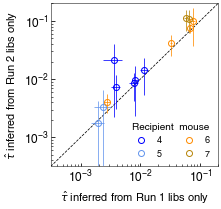

In [133]:
run_comparison_fig, ax = plt.subplots(figsize=(3, 3))

for r, recipient_m in enumerate([4,5,6,7]):
    transmission_measurements_noRun1 = transmission_dict_noRun1[recipient_m]
    transmission_measurements_noRun2 = transmission_dict_noRun2[recipient_m]

    
    color = mouse_colors[recipient_m]

    for (t0, t1), measurements_noRun1 in transmission_measurements_noRun1.items():
        if t1 <= 14 or measurements_noRun1 is None:
            continue
        if (t0, t1) not in transmission_measurements_noRun2.keys() or transmission_measurements_noRun2[(t0, t1)] is None:
            continue
        if t1-t0 > 4:
            continue
        elif t1-t0 == 2 and (t0+1, t1) in transmission_measurements_noRun1:
            continue
        elif t1-t0 == 3 and ((t0+1, t1) in transmission_measurements_noRun1 or (t0+2, t1) in transmission_measurements_noRun1):
            continue
        elif t1-t0 == 4 and ((t0+1, t1) in transmission_measurements_noRun1 \
                             or (t0+2, t1) in transmission_measurements_noRun1 \
                                or (t0+3, t1) in transmission_measurements_noRun1):
            continue
        
        if t1-t0 == 1:
            fmt = 'o'
        elif t1-t0 == 2:
            fmt = 's'
        elif t1-t0 == 3:
            fmt = 'x'
        elif t1-t0 == 4:
            fmt = '^'
        
        measurements_noRun2 = transmission_measurements_noRun2[(t0, t1)]


        m_detect_noRun1, m_detect_err_noRun1  = measurements_noRun1['detected inference']
        m_detect_noRun2, m_detect_err_noRun2  = measurements_noRun2['detected inference']
        ax.errorbar(m_detect_noRun2, m_detect_noRun1, xerr=2*m_detect_err_noRun2, yerr=2*m_detect_err_noRun1, 
                    color=mouse_colors[recipient_m], mfc='none', fmt=fmt)
        
        # m_ratio_noRun1, m_ratio_err_noRun1 = measurements_noRun1['ratio inference']
        # m_ratio_noRun2, m_ratio_err_noRun2 = measurements_noRun2['ratio inference']
        # ax.errorbar(m_ratio_noRun1, m_ratio_noRun2, xerr=m_ratio_err_noRun1, yerr=m_ratio_err_noRun2,
        #             color=mouse_colors[recipient_m], mfc='none', fmt='x')

ax.set_yscale('log')
ax.set_xscale('log')
util.plot_diagonal(ax)
ax.set_xlim(10**-3.5, 0.2)
ax.set_ylim(10**-3.5, 0.2)
ax.set_xlabel(r'$\hat{\tau}$ inferred from Run 1 libs only', fontsize=11)
ax.set_ylabel(r'$\hat{\tau}$ inferred from Run 2 libs only', fontsize=11)
ax.legend(legend_markers, [4,5,6,7], title='Recipient  mouse', ncol=2, loc=4, title_fontsize=10, fontsize=9, frameon=False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(0.5)


plt.rcParams['svg.fonttype'] = 'none'
run_comparison_fig.savefig(f'../figures/sfig_tau_detect_run_comparison.svg', bbox_inches='tight', transparent=True, dpi=300)
run_comparison_fig.savefig(f'../figures/sfig_tau_detect_run_comparison.pdf', transparent=True, bbox_inches='tight')